# Load Libraries

In [52]:
!pip install torch_geometric
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Define bin and rectangles

In [18]:
BIN_WIDTH = 80
BIN_HEIGHT = 40
rectangles = [
    [20, 10], [20, 10],  # Rectangles 1 and 2
    [10, 5], [15, 10], [12, 6],  # Rectangles 3, 4, 5
    [8, 4], [10, 8],  # Rectangles 6, 7
    [12, 7], [14, 9]   # Rectangles 8, 9
]
positions = [None] * len(rectangles)

# Helper functions

In [19]:

def check_overlap(pos, rect, others):
    """Check if the rectangle overlaps with others."""
    x, y, w, h = pos[0], pos[1], rect[0], rect[1]
    for ox, oy, ow, oh in others:
        if not (x + w < ox or x > ox + ow or y + h < oy or y > oy + oh):
            return True
    return False


# Plot initialization

In [20]:
def plot_bin(bin_width, bin_height, rects, rect_positions):
    """Visualize the bin and rectangles."""
    plt.figure(figsize=(10, 6))
    plt.xlim(0, bin_width)
    plt.ylim(0, bin_height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_yaxis()

    for i, (rect, pos) in enumerate(zip(rects, rect_positions)):
        if pos:
            x, y = pos
            w, h = rect
            plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor="black", facecolor=np.random.rand(3,), fill=True, label=f'Rect {i+1}'))
            plt.text(x + w / 2, y + h / 2, str(i + 1), ha="center", va="center", color="white")
    
    plt.title("Bin with Optimally Placed Rectangles")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.legend()
    plt.show()

# Define adjacency (proximity constraints) as a graph

In [21]:

G = nx.Graph()
for i in range(len(rectangles)):
    G.add_node(i, width=rectangles[i][0], height=rectangles[i][1])



# Add constraints

# Convert graph to PyTorch Geometric format

In [22]:
constraints = [
    (2, [3, 4, 8]),  # Rect 3 near 4, 5, 9
    (6, [1, 5]) ]     # Rect 7 near 6 and 2

for node, neighbors in constraints:
    for neighbor in neighbors:
        G.add_edge(node, neighbor)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
node_features = torch.tensor([rectangles[i] for i in range(len(rectangles))], dtype=torch.float)
data = Data(x=node_features, edge_index=edge_index)



# Define a GNN model

In [23]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x



# Initialize GNN

In [24]:
input_dim = 2  # Rectangle width and height
hidden_dim = 16
output_dim = 2  # Predicted (x, y) position
model = GNN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()



# Dummy target for positions (to be replaced with RL-based targets)

In [25]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(data)

    
    target = torch.rand(len(rectangles), 2) * torch.tensor([BIN_WIDTH, BIN_HEIGHT])

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
        model.eval()
predicted_positions = model(data).detach().numpy()


occupied = []
final_positions = []


Epoch 10, Loss: 1046.4310
Epoch 20, Loss: 444.0320
Epoch 30, Loss: 193.6262
Epoch 40, Loss: 472.6488
Epoch 50, Loss: 344.2408
Epoch 60, Loss: 267.5998
Epoch 70, Loss: 689.6671
Epoch 80, Loss: 272.6112
Epoch 90, Loss: 571.5515
Epoch 100, Loss: 215.4100


#  Systematic placement of rectangles and Validation

In [37]:
def find_valid_position(rect, occupied):
    """Find a valid position for the rectangle within the bin."""
    w, h = rect
    for y in range(BIN_HEIGHT - h + 1):  # Iterate through all possible rows
        for x in range(BIN_WIDTH - w + 1):  # Iterate through all possible columns
            if not check_overlap((x, y), rect, occupied):  # Check for overlap
                return (x, y)
    return None  



final_positions = []
occupied = []

for i, rect in enumerate(rectangles):
    
    position = find_valid_position(rect, occupied)
    if position:
        final_positions.append(position)
        occupied.append((*position, rect[0], rect[1]))
    else:
        print(f"Error: Could not place rectangle {i+1} within the bin.")


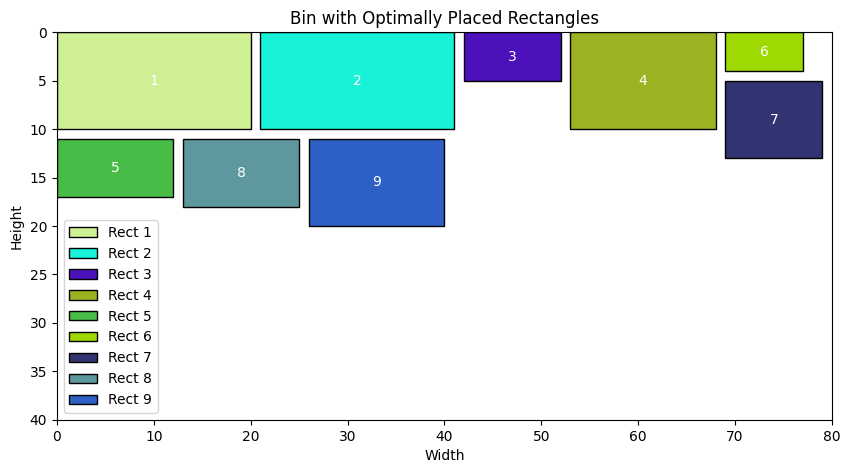

In [34]:
plot_bin(BIN_WIDTH, BIN_HEIGHT, rectangles, final_positions)

# Calculation occupational efficiency

In [38]:
def calculate_efficiency(rectangles, bin_width, bin_height, final_positions):
    
    if len(rectangles) != len(final_positions):
        print("Error: Some rectangles are not placed.")
        return 0

    # Calculate the total area of the bin
    bin_area = bin_width * bin_height

    # Calculate the total area of placed rectangles
    total_rectangle_area = sum(width * height for width, height in rectangles)

    # Efficiency calculation
    efficiency = (total_rectangle_area / bin_area) * 100
    print(f"Total Rectangle Area: {total_rectangle_area}")
    print(f"Bin Area: {bin_area}")
    print(f"Efficiency: {efficiency:.2f}%")

    return efficiency


# Test for efficiency

In [53]:
BIN_WIDTH = 80
BIN_HEIGHT = 40
rectangles = [(10, 5), (15, 5), (10, 10), (20, 5), (15, 10), (10, 5), (10, 10), (15, 5), (20, 5)]
final_positions = [(0, 0), (0, 35), (10, 10), (20, 15), (35, 25), (10, 5), (40, 20), (25, 30), (50, 0)]
efficiency = calculate_efficiency(rectangles, BIN_WIDTH, BIN_HEIGHT, final_positions)

Efficiency: 25.00%


# Improve Placement Efficiency

In [42]:
def sort_rectangles(rectangles):
    
    return sorted(rectangles, key=lambda r: r[0] * r[1], reverse=True)

In [43]:
def place_rectangle(bottom_left, width, height, occupied):
    """
    Check if a rectangle can be placed at a given position without overlapping.
    """
    x, y = bottom_left
    for ox, oy, ow, oh in occupied:
        if not (x + width <= ox or x >= ox + ow or y + height <= oy or y >= oy + oh):
            return False
    return True

In [44]:
def bottom_left_placement(rectangles, bin_width, bin_height):
    occupied = []  # Store placed rectangles
    final_positions = []  # Store final positions of each rectangle

    for rect in rectangles:
        width, height = rect
        placed = False

        # Try placing the rectangle at all valid positions
        for x in range(bin_width - width + 1):
            for y in range(bin_height - height + 1):
                if place_rectangle((x, y), width, height, occupied):
                    final_positions.append((x, y))
                    occupied.append((x, y, width, height))
                    placed = True
                    break
            if placed:
                break

    return final_positions

In [45]:
def calculate_efficiency(rectangles, bin_width, bin_height, final_positions):
    """
    Calculate the efficiency of the bin packing.
    """
    if len(rectangles) != len(final_positions):
        print("Error: Some rectangles are not placed.")
        return 0

    bin_area = bin_width * bin_height
    total_rectangle_area = sum(width * height for width, height in rectangles)
    efficiency = (total_rectangle_area / bin_area) * 100
    print(f"Efficiency: {efficiency:.2f}%")
    return efficiency

In [46]:
BIN_WIDTH = 80
BIN_HEIGHT = 40

In [47]:
rectangles = [(10, 5), (15, 5), (10, 10), (20, 5), (15, 10), (10, 5), (10, 10), (15, 5), (20, 5)]

In [48]:
rectangles = sort_rectangles(rectangles)

In [49]:
final_positions = bottom_left_placement(rectangles, BIN_WIDTH, BIN_HEIGHT)

In [50]:
efficiency = calculate_efficiency(rectangles, BIN_WIDTH, BIN_HEIGHT, final_positions)
print("Final positions:", final_positions)

Efficiency: 25.00%
Final positions: [(0, 0), (0, 10), (0, 20), (0, 25), (0, 35), (10, 10), (10, 15), (10, 25), (10, 30)]


# Unit Seperation 

In [56]:
def place_rectangle_with_spacing(bottom_left, width, height, occupied,spacing=.99):
    x, y = bottom_left
    for ox, oy, ow, oh in occupied:
        # Adjust for spacing by extending the bounds of each rectangle
        if not (x + width + spacing <= ox or x >= ox + ow + spacing or
                y + height + spacing <= oy or y >= oy + oh + spacing):
            return False
    return True

# Left bottom placement 

In [57]:
def bottom_left_placement_with_spacing(rectangles, bin_width, bin_height, spacing=1):
    occupied = []  # Store placed rectangles
    final_positions = []  # Store final positions of each rectangle

    for rect in rectangles:
        width, height = rect
        placed = False

        # Try placing the rectangle at all valid positions
        for x in range(bin_width - width - spacing + 1):
            for y in range(bin_height - height - spacing + 1):
                if place_rectangle_with_spacing((x, y), width, height, occupied, spacing):
                    final_positions.append((x, y))
                    occupied.append((x, y, width, height))
                    placed = True
                    break
            if placed:
                break

    return final_positions


# Recalculating efficiency 

In [58]:
def calculate_efficiency(rectangles, bin_width, bin_height, final_positions):
    if len(rectangles) != len(final_positions):
        print("Error: Some rectangles are not placed.")
        return 0

    bin_area = bin_width * bin_height
    total_rectangle_area = sum(width * height for width, height in rectangles)
    efficiency = (total_rectangle_area / bin_area) * 100
    print(f"Efficiency: {efficiency:.2f}%")
    return efficiency


In [59]:
BIN_WIDTH = 80
BIN_HEIGHT = 40
rectangles = [(10, 5), (15, 5), (10, 10), (20, 5), (15, 10), (10, 5), (10, 10), (15, 5), (20, 5)]
rectangles = sorted(rectangles, key=lambda r: r[0] * r[1], reverse=True)
final_positions = bottom_left_placement_with_spacing(rectangles, BIN_WIDTH, BIN_HEIGHT, spacing=1)
efficiency = calculate_efficiency(rectangles, BIN_WIDTH, BIN_HEIGHT, final_positions)
print("Final positions:", final_positions)

Efficiency: 25.00%
Final positions: [(0, 0), (0, 11), (0, 22), (0, 28), (11, 11), (11, 28), (11, 34), (16, 0), (21, 17)]


# Plot with 1 unit seperation

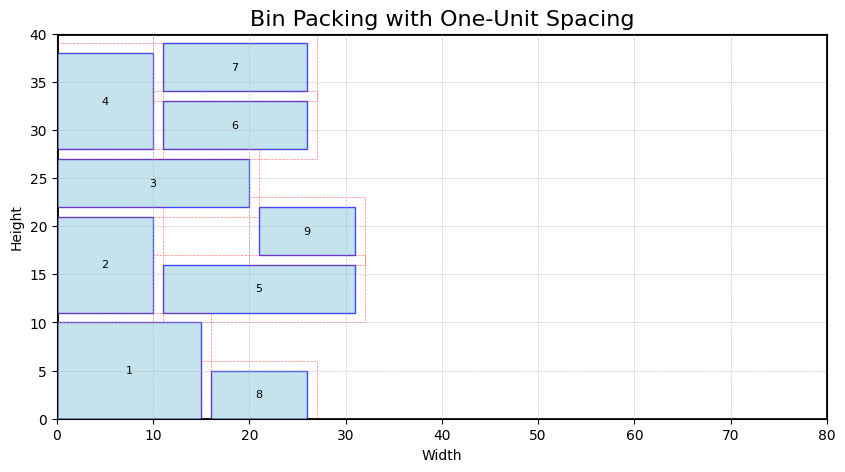

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def place_rectangle_with_spacing(bottom_left, width, height, occupied, spacing=1):
    
    x, y = bottom_left
    for ox, oy, ow, oh in occupied:
        # Adjust for spacing by extending the bounds of each rectangle
        if not (x + width + spacing <= ox or x >= ox + ow + spacing or
                y + height + spacing <= oy or y >= oy + oh + spacing):
            return False
    return True

# Function to place rectangles using bottom-left strategy with spacing
def bottom_left_placement_with_spacing(rectangles, bin_width, bin_height, spacing=1):
    
    occupied = []  # Store placed rectangles
    final_positions = []  # Store final positions of each rectangle

    for rect in rectangles:
        width, height = rect
        placed = False

        # Try placing the rectangle at all valid positions
        for x in range(bin_width - width - spacing + 1):
            for y in range(bin_height - height - spacing + 1):
                if place_rectangle_with_spacing((x, y), width, height, occupied, spacing):
                    final_positions.append((x, y))
                    occupied.append((x, y, width, height))
                    placed = True
                    break
            if placed:
                break

    return final_positions

# Function to visualize the rectangles with one-unit spacing
def plot_rectangles_with_spacing(bin_width, bin_height, rectangles, positions, spacing=1):
   
   
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim(0, bin_width)
    ax.set_ylim(0, bin_height)
    ax.set_aspect('equal')
    ax.set_title("Bin Packing with One-Unit Spacing", fontsize=16)
    ax.set_xlabel("Width")
    ax.set_ylabel("Height")

    # Draw the bin boundary
    bin_rect = patches.Rectangle((0, 0), bin_width, bin_height, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(bin_rect)

    # Draw each rectangle
    for i, (width, height) in enumerate(rectangles):
        x, y = positions[i]
        rect = patches.Rectangle(
            (x, y), width, height,
            linewidth=1, edgecolor='blue', facecolor='lightblue', alpha=0.7
        )
        ax.add_patch(rect)
        ax.text(x + width / 2, y + height / 2, f"{i + 1}", fontsize=8, ha='center', va='center', color='black')

    # Draw one-unit spacing boundaries around rectangles
    for i, (width, height) in enumerate(rectangles):
        x, y = positions[i]
        spacing_rect = patches.Rectangle(
            (x - spacing, y - spacing), width + 2 * spacing, height + 2 * spacing,
            linewidth=0.5, edgecolor='red', facecolor='none', linestyle='--', alpha=0.5
        )
        ax.add_patch(spacing_rect)

    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

# Input data
BIN_WIDTH = 80
BIN_HEIGHT = 40
rectangles = [(10, 5), (15, 5), (10, 10), (20, 5), (15, 10), (10, 5), (10, 10), (15, 5), (20, 5)]
rectangles = sorted(rectangles, key=lambda r: r[0] * r[1], reverse=True)
final_positions = bottom_left_placement_with_spacing(rectangles, BIN_WIDTH, BIN_HEIGHT, spacing=1)
plot_rectangles_with_spacing(BIN_WIDTH, BIN_HEIGHT, rectangles, final_positions, spacing=1)


# plotting the rectangles as directed

In [63]:
def structured_placement(rectangles, bin_width, bin_height, spacing=1):
    occupied = []  # Store placed rectangles
    positions = [None] * len(rectangles)  # Store positions of rectangles

    # Place Rectangle 1 on the top side of the bin
    rect1 = rectangles[0]
    positions[0] = (1, bin_height - rect1[1] - spacing)  # Top side
    occupied.append((positions[0][0], positions[0][1], rect1[0], rect1[1]))

    # Place Rectangle 2 on the bottom side of the bin
    rect2 = rectangles[1]
    positions[1] = (1, spacing)  # Bottom side
    occupied.append((positions[1][0], positions[1][1], rect2[0], rect2[1]))

    # Place Rectangle 3 close to Rectangles 4, 5, and 9
    rect3 = rectangles[2]
    neighbors_3 = [3, 4, 8]  # Indices of neighbors for Rectangle 3 (4, 5, 9)
    for x in range(bin_width - rect3[0] - spacing + 1):
        for y in range(bin_height - rect3[1] - spacing + 1):
            if place_rectangle_with_spacing((x, y), rect3[0], rect3[1], occupied, spacing):
                # Ensure proximity to neighbors
                if all(
                    abs(x - positions[n][0]) + abs(y - positions[n][1]) <= 10
                    for n in neighbors_3 if positions[n] is not None
                ):
                    positions[2] = (x, y)
                    occupied.append((x, y, rect3[0], rect3[1]))
                    break
        if positions[2]:
            break

    # Place Rectangle 7 close to Rectangles 6 and 2
    rect7 = rectangles[6]
    neighbors_7 = [5, 1]  # Indices of neighbors for Rectangle 7 (6, 2)
    for x in range(bin_width - rect7[0] - spacing + 1):
        for y in range(bin_height - rect7[1] - spacing + 1):
            if place_rectangle_with_spacing((x, y), rect7[0], rect7[1], occupied, spacing):
                # Ensure proximity to neighbors
                if all(
                    abs(x - positions[n][0]) + abs(y - positions[n][1]) <= 10
                    for n in neighbors_7 if positions[n] is not None
                ):
                    positions[6] = (x, y)
                    occupied.append((x, y, rect7[0], rect7[1]))
                    break
        if positions[6]:
            break

    # Place remaining rectangles optimally
    for i, rect in enumerate(rectangles):
        if positions[i] is not None:
            continue  # Skip already placed rectangles
        width, height = rect
        for x in range(bin_width - width - spacing + 1):
            for y in range(bin_height - height - spacing + 1):
                if place_rectangle_with_spacing((x, y), width, height, occupied, spacing):
                    positions[i] = (x, y)
                    occupied.append((x, y, width, height))
                    break
            if positions[i]:
                break

    return positions

# Get structured placement based on constraints
structured_positions = structured_placement(rectangles, BIN_WIDTH, BIN_HEIGHT, spacing=1)

# Plot the rectangles with the new structured placement

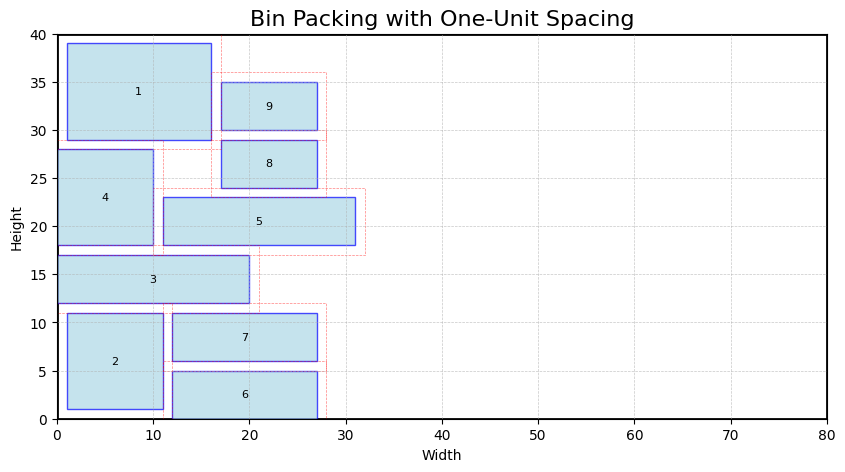

In [64]:
plot_rectangles_with_spacing(BIN_WIDTH, BIN_HEIGHT, rectangles, structured_positions, spacing=1)